> Projeto Desenvolve <br>
Programação Intermediária com Python <br>
Profa. Camila Laranjeira (mila@projetodesenvolve.com.br) <br>

# 3.11 - Data Model

## Exercícios

#### Q1. `dataclass`
Exercício adaptado de [codechalleng.es/bites/154/](https://codechalleng.es/bites/154/) e [codechalleng.es/bites/320/](https://codechalleng.es/bites/320/).

Neste desafio, você deve escrever uma `dataclass` chamada `Bite` que gerencia 3 atributos: `number`, `title` e `level`. Seus tipos são:
* `number` - `int`,
* `title` - `str`,
* `level` -  classe `Enum` chamada `BiteLevel` com os atributos `Beginner`, `Intermediate`, `Advanced`.

Exemplo de dado: `{'number': 154, 'title': 'Escreva uma dataclass', 'level': BiteLevel.Intermediate}`

As características dessa classe são:
* O atributo`level` tem um valor padrão `BiteLevel.Beginner`
* Uma coleção de objetos `Bite` tem que ser ordenável somente pelo atributo `number`
* Implemente o método especial `__str__` para imprimir o Bite na forma `f'{number} - {title} ({level})'`

Teste sua classe executando o seguinte código:
```python
bites = []
bites.append(Bite(154, 'Escreva uma dataclass', 'Intermediate'))
bites.append(Bite(1, 'Some n valores'))
bites.append(Bite(37, 'Reescreva um loop com recursão', 'Intermediate'))

for b in bites.sort(): print(b)
# Ordem esperada na saída:
# 1 - Some n valores (Beginner)
# 37 - Reescreva um loop com recursão (Intermediate)
# 154 - Escreva uma dataclass (Intermediate)
```

In [1]:
from dataclasses import dataclass, field
from enum import Enum

class BiteLevel(Enum):
    Beginner = "Beginner"
    Intermediate = "Intermediate"
    Advanced = "Advanced"

@dataclass(order=True)
class Bite:
    number: int
    title: str = field(compare=False)
    level: BiteLevel = field(default=BiteLevel.Beginner, compare=False)

    def __str__(self):
        level_name = self.level.value if hasattr(self.level, 'value') else self.level
        return f"{self.number} - {self.title} ({level_name})"

bites = []
bites.append(Bite(154, 'Escreva uma dataclass', BiteLevel.Intermediate))
bites.append(Bite(1, 'Some n valores'))
bites.append(Bite(37, 'Reescreva um loop com recursão', BiteLevel.Intermediate))

bites.sort()
for b in bites:
    print(b)

1 - Some n valores (Beginner)
37 - Reescreva um loop com recursão (Intermediate)
154 - Escreva uma dataclass (Intermediate)


#### Q2. `Pydantic`
> Adaptada desse [tutorial de Pydantic](https://github.com/adonath/scipy-2023-pydantic-tutorial/tree/main) criado por [Axel Donath](https://github.com/adonath) e [Nick Langellier](https://github.com/nlangellier).

Observe a seguinte lista de observações da previsão do tempo em Murmansk, Russia.
```python
data_samples = [
    {
        "date": "2023-05-20",
        "temperature": 62.2,
        "isCelsius": False,
        "airQualityIndex": "24",
        "sunriseTime": "01:26",
        "sunsetTime": "00:00",
    },
    {
        "date": "2023-05-21",
        "temperature": "64.4",
        "isCelsius": "not true",
        "airQualityIndex": 23,
        "sunriseTime": "01:10",
        "sunsetTime": "00:16",
    },
    {
        "date": "2023-05-22",
        "temperature": 14.4,
        "airQualityIndex": 21,
    },
]
```

Escreva um script que calcule e imprima a temperatura média (em Celsius) em Murmansk para as datas fornecidas. Em seu script, você deve incluir um modelo Pydantic que registre com sucesso todos os elementos dados. Note que:

* Algumas amostras estão faltando dados. Você deve decidir quando o atributo pode ter um valor padrão ou quando definí-lo como opcional (`typing.Optional`).
* Você precisará implementar pelo menos um validador de campo para transformar atributos. Dica: teste primeiro quais vão falhar :)



In [2]:
from pydantic import BaseModel, field_validator
from typing import Optional, List
from datetime import date

class WeatherData(BaseModel):
    date: date
    temperature: float
    isCelsius: bool = True
    airQualityIndex: Optional[int] = None
    sunriseTime: Optional[str] = None
    sunsetTime: Optional[str] = None

    @field_validator('isCelsius', mode='before')
    @classmethod
    def parse_bool(cls, v):
        if isinstance(v, str) and v.lower() == "not true":
            return False
        return v

data_samples = [
    {
        "date": "2023-05-20",
        "temperature": 62.2,
        "isCelsius": False,
        "airQualityIndex": "24",
        "sunriseTime": "01:26",
        "sunsetTime": "00:00",
    },
    {
        "date": "2023-05-21",
        "temperature": "64.4",
        "isCelsius": "not true",
        "airQualityIndex": 23,
        "sunriseTime": "01:10",
        "sunsetTime": "00:16",
    },
    {
        "date": "2023-05-22",
        "temperature": 14.4,
        "airQualityIndex": 21,
    },
]

models = []
for item in data_samples:
    m = WeatherData(**item)
    if not m.isCelsius:
        m.temperature = (m.temperature - 32) * 5/9
    models.append(m)

avg_temp = sum(m.temperature for m in models) / len(models)
print(f"{avg_temp:.2f}")

16.39


#### Q3
> Adaptada desse [tutorial de Pydantic](https://github.com/adonath/scipy-2023-pydantic-tutorial/tree/main) criado por [Axel Donath](https://github.com/adonath) e [Nick Langellier](https://github.com/nlangellier).

Na célula a seguir, coletamos dados reais de uma das principais APIs de previsão do tempo, [open-meteo](https://open-meteo.com/en/docs). Não se preocupe em entender esse código, o mais importante é entender o resultado que ele retorna, ilustrado a seguir para uma coleta da temperatura dos últimos 15 dias em Itabira -MG. Caso deseje alterar a cidade de coleta, basta alimentar a latitude e longitude desejada, como nas opções a seguir.
* Itabira: `'latitude': -19.656655787605846, 'longitude': -43.228922960534476`
* Bom Despacho: `'latitude': -19.726308457732443, 'longitude': -45.27462803349767`

```python
{
  "latitude": -19.5,
  "longitude": -43.375,
  "generationtime_ms": 0.01800060272216797,
  "utc_offset_seconds": 0,
  "timezone": "GMT",
  "timezone_abbreviation": "GMT",
  "elevation": 2.0,
  "hourly_units": {
    "time": "iso8601",
    "temperature_2m": "\u00b0C"
  },
  "hourly": {
    "time": [
      "2024-07-19T00:00",
      "2024-07-19T01:00",
      "2024-07-19T02:00",
      ...
    ],
    "temperature_2m": [
      21.9,
      20.9,
      20.0,
      ...
    ]
  }
}
```

Você deve escrever um modelo Pydantic `OpenMeteo` que receba diretamente a resposta dessa API, através do comando:
```python
dados = OpenMeteo(**response)
```

Para comportar a estrutura hierárquica desse dicionário (é um dicionário com alguns dicionários internos), você deve criar uma classe Pydantic para cada dicionário interno (`HourlyUnits` e `Hourly`), com seus respectivos atributos. Essas classes serão atributos da classe principal `OpenMeteo`, que terá também os outros atributos da resposta (`latitude`, `longitude`, etc.).



In [3]:
import requests, json

url = 'https://api.open-meteo.com/v1/forecast'
lat, long = -19.656655787605846, -43.228922960534476
params = {'latitude': lat, 'longitude': long, 'elevation': 2,
          'hourly': 'temperature_2m', 'forecast_days': 15}
response = requests.get(url, params=params).json()
print(json.dumps(response, indent=2))

{
  "latitude": -19.625,
  "longitude": -43.25,
  "generationtime_ms": 0.05745887756347656,
  "utc_offset_seconds": 0,
  "timezone": "GMT",
  "timezone_abbreviation": "GMT",
  "elevation": 2.0,
  "hourly_units": {
    "time": "iso8601",
    "temperature_2m": "\u00b0C"
  },
  "hourly": {
    "time": [
      "2026-01-05T00:00",
      "2026-01-05T01:00",
      "2026-01-05T02:00",
      "2026-01-05T03:00",
      "2026-01-05T04:00",
      "2026-01-05T05:00",
      "2026-01-05T06:00",
      "2026-01-05T07:00",
      "2026-01-05T08:00",
      "2026-01-05T09:00",
      "2026-01-05T10:00",
      "2026-01-05T11:00",
      "2026-01-05T12:00",
      "2026-01-05T13:00",
      "2026-01-05T14:00",
      "2026-01-05T15:00",
      "2026-01-05T16:00",
      "2026-01-05T17:00",
      "2026-01-05T18:00",
      "2026-01-05T19:00",
      "2026-01-05T20:00",
      "2026-01-05T21:00",
      "2026-01-05T22:00",
      "2026-01-05T23:00",
      "2026-01-06T00:00",
      "2026-01-06T01:00",
      "2026-01-06T02:0

In [4]:
from pydantic import BaseModel
from typing import List

class HourlyUnits(BaseModel):
    time: str
    temperature_2m: str

class HourlyData(BaseModel):
    time: List[str]
    temperature_2m: List[float]

class OpenMeteo(BaseModel):
    latitude: float
    longitude: float
    generationtime_ms: float
    utc_offset_seconds: int
    timezone: str
    timezone_abbreviation: str
    elevation: float
    hourly_units: HourlyUnits
    hourly: HourlyData

dados_validados = OpenMeteo(**response)

#### Q4.

Com os dados carregados na questão anterior plote um gráfico de linha, com a biblioteca de sua preferência, onde o eixo `x` são os timestamps (data e hora) e o eixo `y` é a temperatura medida.

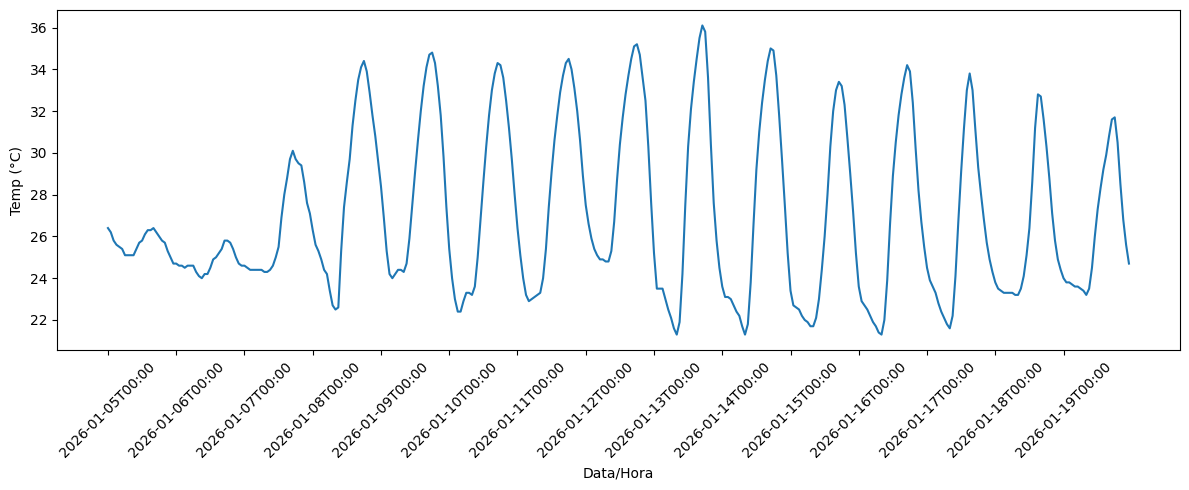

In [5]:
import matplotlib.pyplot as plt

timestamps = dados_validados.hourly.time
temperaturas = dados_validados.hourly.temperature_2m

plt.figure(figsize=(12, 5))
plt.plot(timestamps, temperaturas)
plt.xticks(timestamps[::24], rotation=45)
plt.ylabel(f"Temp ({dados_validados.hourly_units.temperature_2m})")
plt.xlabel("Data/Hora")
plt.tight_layout()
plt.show()